# DUFFING TRANSFORMER

In [1]:
# Equation Params
delta = 0.02
beta = 1
alpha = 5
gamma = 7
omega = 0.5
initial_conditions = [0, 0] # initial conditions

# Time Params
t_end = 100                  # t final
t_points = 10000             # points
lyapunov_exponent = 1       # set to 1 to ignore lyapunov

# Split Param
split_ratio = 1/8

# Scaler Params (don't modify unless you know what you are doing)
feature_range = (0, 1)

# Model Hyperparams (don't need to modify unless want to)
learning_rate = 0.001
epochs = 400
batch_size = 1000 # increasing batch size to = total points maximizes processing

# Params for the iterative forecast 
num_iterations = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, MultiHeadAttention, LayerNormalization, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# define duffing oscillator equation


def duffing_oscillator(y, t, delta, alpha, beta, gamma, omega):
    x, x_dot = y
    x_dot_dot = -delta * x_dot - beta * x - alpha * x**3 + gamma * np.cos(omega * t)
    return [x_dot, x_dot_dot]

# define time span
t = np.linspace(0, t_end, t_points)

# compute Lyapunov time
lyapunov_time = 1 / np.abs(lyapunov_exponent)
t_lyapunov = t / lyapunov_time

# define initial conditions
initial_conditions = [0, 0]

# solve Duffing equation using odeint

solution = odeint(duffing_oscillator, initial_conditions, t_lyapunov, args=(delta, alpha, beta, gamma, omega))

solution = solution[:, 0]

# split data into input and ground truth
points_length = int(len(solution) * split_ratio)
input_solution = solution[:points_length]
ground_truth_solution = solution[points_length:]

X_train, X_test = input_solution, ground_truth_solution
time_train, time_test = t_lyapunov[:points_length], t_lyapunov[points_length:]

# scale input data
scaler = MinMaxScaler(feature_range=feature_range)
X_train_normalized = scaler.fit_transform(X_train.reshape(-1, 1))
y_train_normalized = scaler.transform(X_test.reshape(-1, 1))

X_train_normalized = np.reshape(X_train_normalized, (-1, 1, 1))

# --------------------------------------------------------------------------------------------------------------------
def transformer_model(input_shape, num_layers=8, d_model=12, num_heads=1, dff=12, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Positional encoding
    input_length = input_shape[0]  # Assuming input_shape is (sequence_length, features)
    pos_encoding = np.arange(input_length)[:, np.newaxis] / np.power(100000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
    x += pos_encoding
    
    # Transformer Encoder layers 
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
        # attn_output = Dropout(dropout_rate)(attn_output)
        # out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Position-wise feedforward network
        ffnn = Dense(dff, activation='relu') #(out1)
        # ffnn = Dense(d_model)(ffnn)
        # ffnn = Dropout(dropout_rate)(ffnn)
        # out2 = LayerNormalization(epsilon=1e-6)(out1 + ffnn)
        # x = out2
    
    # Output layer
    outputs = Dense(1, activation='linear')(x)  # Linear activation for single value output
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model = transformer_model(input_shape=(X_train_normalized.shape[1], 1))

# compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# train the model
model.fit(X_train_normalized, X_train_normalized, epochs=epochs, batch_size=batch_size, verbose=1)

# predict using the trained model
predicted_solution_normalized = model.predict(y_train_normalized)

# inverse transform predicted solution to original scale
predicted_solution = scaler.inverse_transform(predicted_solution_normalized.reshape(-1, 1)).flatten()

Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - loss: 0.2060   
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1886 
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1715  
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1560 
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1415 
Epoch 6/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1295  
Epoch 7/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1184  
Epoch 8/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1076
Epoch 9/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1015  
Epoch 10/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0955 
Epoch 11/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0901
Epoch 12/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0857 
Epoch 13/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0826 
Epoch 14/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0813
Epoch 15/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0796  
Epoch 16/400
2/2 

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.1069e-05
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 7.9926e-05
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.8768e-05
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.7604e-05
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.6441e-05
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.5286e-05
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.4148e-05
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.3032e-05
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.1941e-05
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.0876e-05
Epoch 11/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.9836e-05
Epoch 12/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.8819e-05
Epoch 13/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.7821e-05
Epoch 14/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.6840e-05
Epoch 15/400
1/1 ━━━━━━━━━━━━

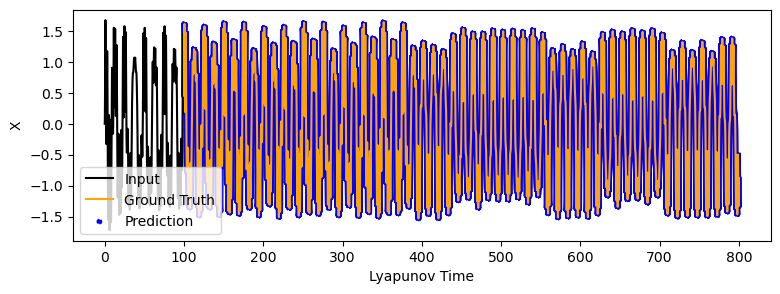

In [3]:
def iterative_forecast(model, initial_input, scaler, num_iterations, split_num, epochs):
    all_predictions = initial_input.copy()  # Make a copy of initial input
    for i in range(num_iterations):
        # define time span
        split_num = int(1/split_num)
        t = np.linspace(0, t_end*split_num**(i+1), t_points*split_num**(i+1))
        t = t / lyapunov_time

        # lorenz solved
        solution = odeint(duffing_oscillator, initial_conditions, t, args=(delta, alpha, beta, gamma, omega))
        solution = solution[:, 0].reshape(-1, 1)
        points_length = int(len(solution) * split_ratio)
        input_solution = all_predictions
        ground_truth_solution = solution[points_length:]

        # normalize input data
        input_data_scaled = scaler.fit_transform(input_solution.reshape(-1, 1))
        ground_truth_solution_scaled = scaler.transform(ground_truth_solution.reshape(-1, 1))
        input_data_scaled = np.reshape(input_data_scaled, (-1, 1, 1))
    
        # train
        model.fit(input_data_scaled, input_data_scaled, epochs=epochs, batch_size=t_points, verbose=1)
        # predict
        predicted_solution_normalized = model.predict(ground_truth_solution_scaled)

        # back to original
        predicted_solution_normalized_2d = predicted_solution_normalized.reshape(-1, 1)
        predicted_solution = scaler.inverse_transform(predicted_solution_normalized_2d).flatten()

        # append
        all_predictions = np.concatenate((all_predictions, predicted_solution))

        plt.figure(figsize=(9, 3))
        plt.plot(t[:points_length], input_solution, label='Input', color='black')
        plt.plot(t[points_length:], ground_truth_solution, label='Ground Truth', color='orange')
        plt.scatter(t[points_length:], predicted_solution, label='Prediction', color='blue', linestyle='--', s=10)
        plt.xlabel('Lyapunov Time')
        plt.ylabel('X')
        plt.legend()

# perform recursive prediction for x variable
all_predictions_x = iterative_forecast(model, np.concatenate((input_solution, predicted_solution.reshape(-1))), scaler, num_iterations, split_ratio, epochs)

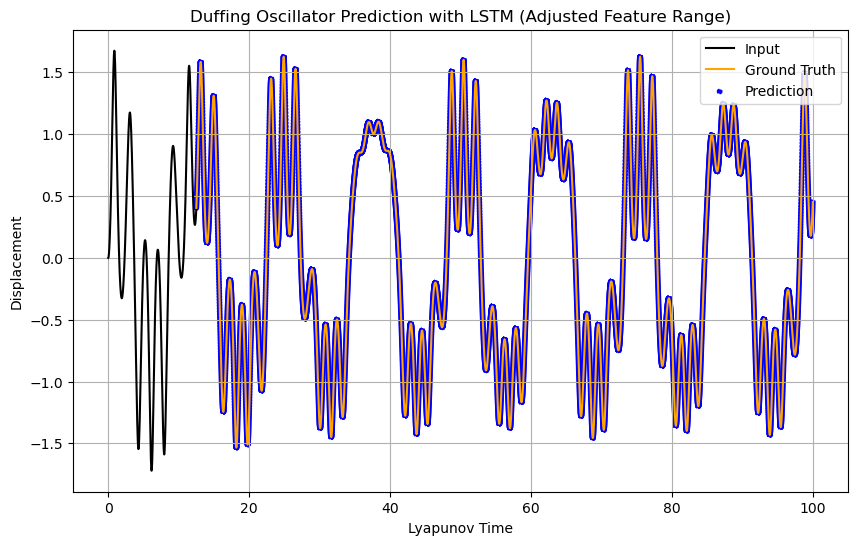

In [12]:
# plot results
plt.figure(figsize=(10, 6))
plt.plot(t_lyapunov[:points_length], input_solution, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('Displacement')
plt.title('Duffing Oscillator Prediction with LSTM (Adjusted Feature Range)')
plt.legend()
plt.grid(True)
plt.show()